In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from typing import Callable
from my_SSIF_functions import *
import time

In [2]:
start_time = time.time()

# relevant time scale -- minutes (min)
# relevant space scale -- micrometers (mum)

# Model parameters
v0 = 4  # mum/min (estimated) --> motor velocity without load
f0 = 5  # pN (Valentine et al. 2006) --> stall force of sliding motors
mu_KC = 30  # pN*min/mum (estimated) --> friction coefficient of kinetochore-kMT interaction
mu_c = 1  # --> friction coefficient of single crosslinker
n_c = 1  # only product of n_c*mu_c is relevant, 1 pN*min/mum^2 (estimated) --> linear density of crosslinkers
n_m = 10  # mum^-1 (estimated) --> linear density of motors
d = 1  # mum (measured) --> interkinetochore distance
L0 = 14  # mum (measured) --> spindle length
D0 = 6  # mum (measured) --> bMT antiparallel overlap length

parameters = (v0, f0, mu_KC, mu_c, n_c, n_m, d, L0, D0)  # pack the parameters in a tuple for conveniency

# mum = micrometer

In [3]:
# Apply finite difference method for integrating kinetochore velocity
t = np.linspace(0, 10, 1000)  # in minutes, time points in which to calculate v_KC and x_KC

x0 = -2.5  # left kinetochore initial position
x_KC_minus = finite_difference(calculate_v_KC, t, x0, parameters)
x_KC_plus = x_KC_minus + d

x_bMT_plus = finite_difference(lambda x: 0.5*v0, t, 0)
x_bMT_minus = finite_difference(lambda x: -0.5*v0, t, 0)

# Calculate k-fiber element position vs time using finite difference method
# Cannot use finite_difference funtion because v_kMT depends on x_KC and not x_kMT
x_kMT_plus = np.zeros(t.size)
x_kMT_minus = np.zeros(t.size)
x_kMT_plus[0] = x_KC_plus[0]  # set initial position of right k-fiber element you want to track over time
x_kMT_minus[0] = x_KC_minus[0]

for i in range(1, t.size):
    x_kMT_plus[i] = x_kMT_plus[i-1] + calculate_v_kMT_plus(*parameters, x_KC_plus[i-1]) * (t[i] - t[i-1])
    x_kMT_minus[i] = x_kMT_minus[i-1] + calculate_v_kMT_minus(*parameters, x_KC_minus[i-1]) * (t[i] - t[i-1])

In [4]:
# Calculate and plot k-fiber velocity and kinetochore velocity

v_kMT_minus = calculate_v_kMT_minus(*parameters, x_KC_minus)
v_kMT_plus = calculate_v_kMT_plus(*parameters, x_KC_plus)
#x_KC_plus_derivative = calculate_forward_derivative(t, x_KC_plus)
#x_KC_minus_derivative = calculate_forward_derivative(t, x_KC_minus)
v_KC = calculate_v_KC(*parameters, x_KC_minus)

In [5]:
# Check consistency of kMT force balance (Equation 5)
D_plus = (D0/2 - x_KC_plus) * np.heaviside(D0/2 - x_KC_plus, 0)
D_minus = (D0/2 + x_KC_minus) * np.heaviside(D0/2 + x_KC_minus, 0)
F_m_plus = D_plus * n_m * f0 * (1 - (v_kMT_plus - (-v0/2))/v0)  # force of motors on right k-fiber
F_m_minus = D_minus * n_m * f0 * (-1 - (v_kMT_minus - v0/2)/v0)

L_plus = L0/2 - x_KC_plus
L_minus = L0/2 + x_KC_minus
F_c_plus = n_c * L_plus * mu_c * (v_kMT_plus - v0/2)  # force of crosslinkers on right bridging fiber
F_c_minus = n_c * L_minus * mu_c * (v_kMT_minus - (-v0/2))

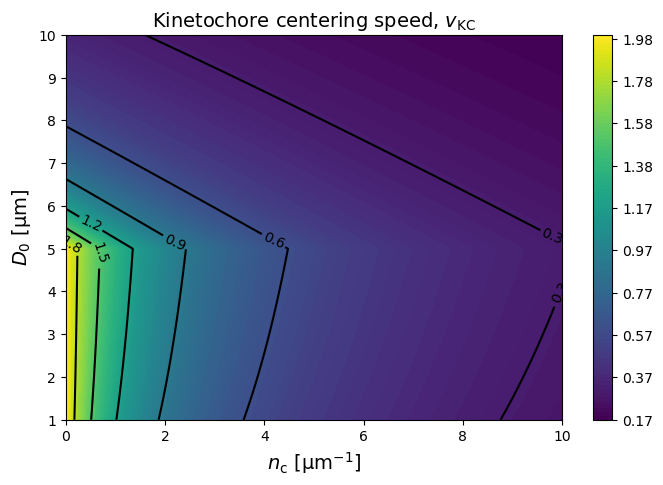

In [6]:
# Plot contour plot of kinetochore centering velocity versus crosslinker density and bMT overlap D_0

X1 = np.linspace(0, 10, 1000)  # crosslinker density
Y1 = np.linspace(1, 10, 1000)  # bMT overlap D0
X1, Y1 = np.meshgrid(X1, Y1)

Z1 = calculate_v_KC(v0, f0, mu_KC, mu_c, X1, n_m, d, L0, Y1, x0)
cs_filled_levels_1 = np.linspace(Z1.min(), Z1.max(), 101)
cs_line_levels_1 = np.linspace(0, 3, 11)

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
cs_filled_1 = ax1.contourf(X1, Y1, Z1, cmap="viridis", levels=cs_filled_levels_1)
cs_lines_1 = ax1.contour(X1, Y1, Z1, colors="k", levels=cs_line_levels_1)
ax1.clabel(cs_lines_1, inline=True)
fig1.colorbar(cs_filled_1, format="{x:.2f}")
ax1.set_xlabel(r"$n_\mathrm{c}\ [\mathrm{\mu m^{-1}}]$", size=14)
ax1.set_ylabel(r"$D_0\ [\mathrm{\mu m}]$", size=14)
ax1.set_title(r"Kinetochore centering speed, $v_{\mathrm{KC}}$", size=14)

plt.show()

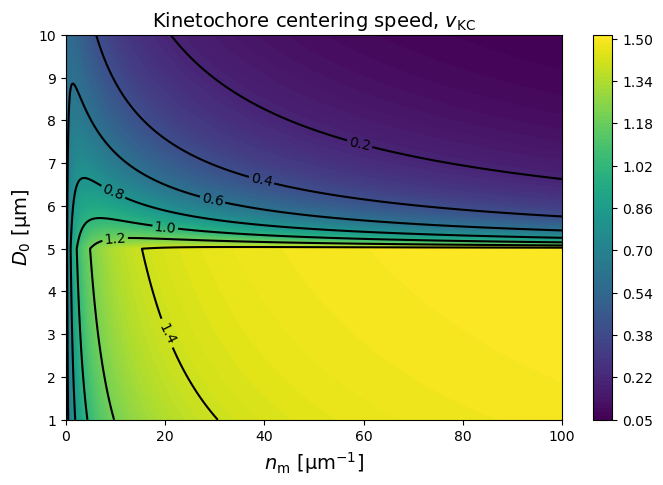

In [18]:
# Plot contour plot of kinetochore centering speed versus motor density and bMT overlap

X2 = np.linspace(0, 100, 1000)  # motor density
Y2 = np.linspace(1, 10, 1000)  # bMT overlap D0
X2, Y2 = np.meshgrid(X2, Y2)

Z2 = calculate_v_KC(v0, f0, mu_KC, mu_c, n_c, X2, d, L0, Y2, x0)

cs_filled_levels_2 = np.linspace(Z2.min(), Z2.max(), 101)
cs_line_levels_2 = np.arange(np.floor(Z2.min()), np.ceil(Z2.max()), 0.2)
label_locs = [(20, 3), (10, 5), (20, 5.5), (10, 6.5), (30, 6.5), (40, 7), (60, 8)]

fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
cs_filled_2 = ax2.contourf(X2, Y2, Z2, levels=cs_filled_levels_2)
cs_lines_2 = ax2.contour(X2, Y2, Z2, levels=cs_line_levels_2, colors="k")
ax2.clabel(cs_lines_2, inline=True, fontsize=10, manual=label_locs)
fig2.colorbar(cs_filled_2, format="{x:.2f}")
ax2.set_xlabel(r"$n_\mathrm{m}\ [\mathrm{\mu m^{-1}}]$", size=14)
ax2.set_ylabel(r"$D_0\ [\mathrm{\mu m}$]", size=14)
ax2.set_title(r"Kinetochore centering speed, $v_{\mathrm{KC}}$", size=14)

plt.show()